#### Association 101
Association rules are normally written like this: {Milk} -> {Butter} which means that there is a strong relationship between customers that purchased Milk and also purchased Butter in the same transaction.

In the above example, the {Milk} is the antecedent and the {Butter} is the consequent. Both antecedents and consequents can have multiple items. In other words, {Milk, Eggs} -> {Butter, CakeMix} is a valid rule.

#### Support is the relative frequency that the rules show up. In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.

#### Confidence is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where Milk & Eggs were purchased, the purchase also included Butter and CakeMix. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

#### Lift is the ratio of the observed support to that expected if the two rules were independent (see wikipedia). The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

Association analysis is relatively light on the math concepts and easy to explain to non-technical people. In addition, it is an unsupervised learning tool that looks for hidden patterns so there is limited need for data prep and feature engineering. It is a good start for certain cases of data exploration and can point the way for a deeper dive into the data using other approaches.

In [1]:
# Source: https://pbpython.com/market-basket-analysis.html

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_excel('Online_retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.shape

(541909, 8)

<AxesSubplot:>

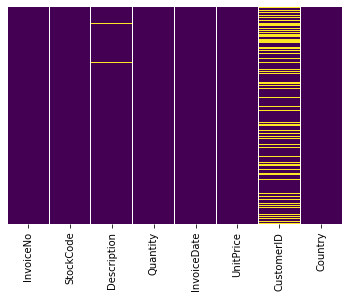

In [3]:
#Visualise if dataset has null values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There is a little cleanup, we need to do. First, some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

In [4]:
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

<AxesSubplot:>

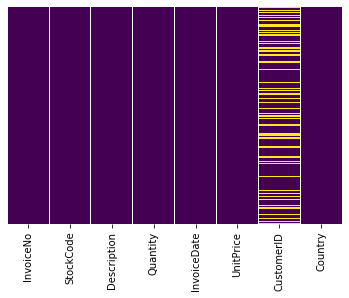

In [5]:
#Visualise again if dataset has been cleaned up
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, I’m only looking at sales for France. However, in additional code below, I will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

In [8]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. This step will complete the one hot encoding of the data and remove the postage column (since that charge is not one we wish to explore):

In [9]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that I could get enough useful examples):

In [10]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

The final step is to generate the rules with their corresponding support, confidence and lift:

In [11]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN SPACEBOY),0.143167,0.117137,0.075922,0.530303,4.527217,0.059152,1.879645
1,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE ),0.117137,0.143167,0.075922,0.648148,4.527217,0.059152,2.435209
2,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.143167,0.145336,0.086768,0.606061,4.170059,0.065961,2.169531
3,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE ),0.145336,0.143167,0.086768,0.597015,4.170059,0.065961,2.126215
4,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.117137,0.145336,0.088937,0.759259,5.224157,0.071913,3.550142


That’s all there is to it! Build the frequent items using apriori then build the rules with association_rules .

Now, the tricky part is figuring out what this tells us. For instance, we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy. Since I do not have that, I’ll just look for a couple of illustrative examples.

We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):

In [12]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.117137,0.108460,0.104121,0.888889,8.195556,0.091417,8.023861
11,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.108460,0.117137,0.104121,0.960000,8.195556,0.091417,22.071584
12,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",(SET/6 RED SPOTTY PAPER PLATES),0.086768,0.108460,0.084599,0.975000,8.989500,0.075188,35.661605
13,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",(SET/6 RED SPOTTY PAPER CUPS),0.086768,0.117137,0.084599,0.975000,8.323611,0.074435,35.314534
14,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS ),0.104121,0.112798,0.084599,0.812500,7.203125,0.072854,4.731743


In looking at the rules, it seems that the green and red alarm clocks are purchased together and the red paper cups, napkins and plates are purchased together in a manner that is higher than the overall probability would suggest.

At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 340 Green Alarm clocks but only 316 Red Alarm Clocks (pls note there is a space after "RED " else it will give error) so maybe we can drive more Red Alarm Clock sales through recommendations?

In [31]:
basket['ALARM CLOCK BAKELIKE GREEN'].sum()

339.0

In [33]:
basket['ALARM CLOCK BAKELIKE RED '].sum()

316.0

What is also interesting is to see how the combinations vary by country of purchase. Let’s check out what some popular combinations might be in Germany:

In [17]:
basket2 = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.05, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE ),(PLASTERS IN TIN WOODLAND ANIMALS),0.087894,0.104478,0.051410,0.584906,5.598383,0.042227,2.157395
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.185738,0.119403,0.099502,0.535714,4.486607,0.077325,1.896670
5,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.119403,0.185738,0.099502,0.833333,4.486607,0.077325,4.885572
